In [109]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [160]:
def correct_data(df):
    """
    Corrects the data by removing outliers and interpolating missing values.

    Parameters:
    - df: pandas DataFrame with at least two columns: 'timestamp' and 'load'.

    Returns:
    - df: corrected pandas DataFrame.
    """
    # Remove outliers
    df = df.copy()
    df['load_diff'] = df['load'].diff(periods=1)
    outlier_idx = df['load_diff'].abs().idxmax()
    df.loc[outlier_idx-2:outlier_idx+2, 'load'] = None
    df['load'] = df['load'].interpolate(method='linear')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df.index = df.index.round('5min')
    df = df.asfreq('5min')
    df = df.interpolate()

    return df


def add_time_features(df, interval_minutes=5):
    """
    Adds sin_time and cos_time features based on the time of day, assuming a fixed interval in minutes.

    Parameters:
        df (pd.DataFrame): DataFrame with a datetime index.
        interval_minutes (int): Time interval between observations in minutes (default is 5).

    Returns:
        pd.DataFrame: DataFrame with 'sin_time' and 'cos_time' columns added.
    """
    df = df.copy()

    minutes_in_day = 24 * 60
    steps_per_day = minutes_in_day // interval_minutes

    time_of_day = (df.index.hour * 60 + df.index.minute) / interval_minutes
    angle = 2 * np.pi * time_of_day / steps_per_day

    df['sin_time'] = np.sin(angle)
    df['cos_time'] = np.cos(angle)

    return df

def split_train_test(df, train_frac=0.7, val_frac=0.15):
    """
    Splits the DataFrame into train, validation, and test sets by index (time-based).

    Parameters:
        df (pd.DataFrame): The full dataset.
        train_frac (float): Fraction of data to use for training.
        val_frac (float): Fraction of data to use for validation.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: (train_df, val_df, test_df)
    """
    n = len(df)
    train_end = int(n * train_frac)
    val_end = train_end + int(n * val_frac)

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, val_df, test_df



def transform_series(df, use_boxcox=True):
    """
    Applies Box-Cox (optional) and StandardScaler to the 'load' column.

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'load' column.
        use_boxcox (bool): Whether to apply Box-Cox transform before scaling.

    Returns:
        Tuple[pd.DataFrame, dict]: Transformed DataFrame, and scalers dict with Box-Cox lambda and StandardScaler.
    """
    df = df.copy()
    scalers = {}

    series = df['load'].values
    scalers['load'] = {}

    if use_boxcox:
        series, lam = boxcox(series)
        scalers['load']['lambda'] = lam

    scaler = StandardScaler()
    df['load'] = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    scalers['load']['scaler'] = scaler

    return df, scalers

def apply_transformation(df, scalers, use_boxcox=True):
    """
    Applies previously fitted Box-Cox and StandardScaler to 'load' column in a new DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with 'load' column to transform.
        scalers (dict): Dictionary with 'lambda' and 'scaler' from transform_series.
        use_boxcox (bool): Should match the flag used during training.

    Returns:
        pd.DataFrame: Transformed DataFrame.
    """
    df = df.copy()
    series = df['load'].values

    if use_boxcox:
        lam = scalers['load']['lambda']
        series = boxcox(series, lmbda=lam)

    scaler = scalers['load']['scaler']
    df['load'] = scaler.transform(series.reshape(-1, 1)).flatten()


    return df

from scipy.special import inv_boxcox

def inverse_transform(series, scaler, boxcox_lambda=None):
    """
    Inverts StandardScaler (and Box-Cox if lambda is provided) on a 2D series.

    Parameters:
        series (ndarray): Shape [n_samples, horizon]
        scaler (StandardScaler): fitted scaler object
        boxcox_lambda (float or None): lambda used in boxcox (optional)

    Returns:
        ndarray: Series restored to original scale
    """
    # Step 1: inverse standard scaling
    reshaped = series.reshape(-1, 1)
    unscaled = scaler.inverse_transform(reshaped).reshape(series.shape)

    # Step 2: inverse box-cox if needed
    if boxcox_lambda is not None:
        unscaled = inv_boxcox(unscaled, boxcox_lambda)

    return unscaled



def create_sliding_windows(df, lookback, horizon):
    X, y = [], []
    data = df[['load', 'sin_time', 'cos_time']].values

    for i in range(len(data) - lookback - horizon + 1):
        x_window = data[i:i+lookback]
        y_window = data[i+lookback:i+lookback+horizon, 0]  # only 'load' as target

        X.append(x_window)
        y.append(y_window)

    X = np.array(X)  # shape: [num_samples, lookback, features]
    y = np.array(y)  # shape: [num_samples, horizon]

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def compute_forecast_metrics(y_true, y_pred):
    """
    Computes MAE and MAPE per forecast horizon and returns a DataFrame summary.

    Parameters:
        y_true (Tensor or ndarray): Shape [num_samples, horizon]
        y_pred (Tensor or ndarray): Same shape as y_true

    Returns:
        pd.DataFrame: DataFrame with MAE, MAPE per horizon, and overall metrics
    """
    if hasattr(y_true, 'detach'):  # torch.Tensor
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    horizon = y_true.shape[1]
    rows = []

    for i in range(horizon):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])
        rows.append({'horizon': i + 1, 'MAE': mae, 'MAPE': mape})

    df = pd.DataFrame(rows)
    overall = pd.DataFrame([{
        'horizon': 'overall',
        'MAE': df['MAE'].mean(),
        'MAPE': df['MAPE'].mean()
    }])

    return pd.concat([df, overall], ignore_index=True)

In [240]:
def plot_test_vs_pred_time(test_df, y_true_inv, y_pred_inv, horizons=None, title="Forecast vs Actual"):
    """
    Plots actual and predicted values over time for selected forecast horizons.

    Parameters:
        test_df (pd.DataFrame): Original test DataFrame with DateTime index
        y_true_inv (ndarray): [num_samples, horizon] inverse-transformed true values
        y_pred_inv (ndarray): same shape
        horizons (int or list[int] or None):
            - int: plot only that horizon (1-based index)
            - list[int]: plot each selected horizon separately
            - None: plot all horizons
        title (str): Plot title
    """
    if hasattr(y_true_inv, "detach"): y_true_inv = y_true_inv.detach().cpu().numpy()
    if hasattr(y_pred_inv, "detach"): y_pred_inv = y_pred_inv.detach().cpu().numpy()

    num_samples, max_h = y_true_inv.shape

    # Normalize horizons input to 0-based list
    if horizons is None:
        selected_horizons = list(range(max_h))
    elif isinstance(horizons, int):
        selected_horizons = [horizons - 1]
    else:
        selected_horizons = [h - 1 for h in horizons]

    for h in selected_horizons:
        # Align timestamp index to each horizon
        aligned_index = test_df.index[-(num_samples + h):-h or None]

        # Ensure the slice fits
        if len(aligned_index) != num_samples:
            raise ValueError(f"Mismatch for horizon {h+1}: {len(aligned_index)} timestamps vs {num_samples} predictions")

        plt.figure(figsize=(12, 4))
        plt.plot(aligned_index, y_true_inv[:, h], label='Actual', linewidth=2)
        plt.plot(aligned_index, y_pred_inv[:, h], label='Predicted', linewidth=2, linestyle='--')
        plt.title(f"{title} (Horizon {h + 1})")
        plt.xlabel("Time")
        plt.ylabel("Load")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [224]:
# df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
# df = correct_data(df).iloc[1:]
# if 'load_diff' in df.columns:
#     df = df.drop(columns=['load_diff'])
#
# df = add_time_features(df)
# train_df, test_df = split_train_test(df)
# train_df_t, scalers = transform_series(train_df, use_boxcox=True)
# test_df_t = apply_transformation(test_df, scalers, use_boxcox=True)

In [225]:
class LSTMForecast(nn.Module):
    def __init__(self,
                 input_size=12,
                 hidden_size=32,
                 output_size=24,
                 num_layers=1,
                 lstm_dropout=0.2,
                 final_dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout)
        self.dropout = nn.Dropout(final_dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)  # Apply dropout
        out = self.fc(out)   # Get the last time step's output
        return out

In [262]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, targets in tqdm(train_loader, leave=False, desc="Train", dynamic_ncols=True):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_preds.append(outputs.detach().cpu())
            train_targets.append(targets.cpu())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()
        train_mae = mean_absolute_error(train_targets, train_preds)
        train_mape = mean_absolute_percentage_error(train_targets, train_preds)

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, leave=False, desc="Val", dynamic_ncols=True):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                val_preds.append(outputs.cpu())
                val_targets.append(targets.cpu())

        avg_val_loss = val_loss / len(test_loader.dataset)
        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        val_mae = mean_absolute_error(val_targets, val_preds)
        val_mape = mean_absolute_percentage_error(val_targets, val_preds)

        print(f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        print(f"Train MAE: {train_mae:.4f} | MAPE: {train_mape:.2%} | Val MAE: {val_mae:.4f} | MAPE: {val_mape:.2%}")

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    eval_bar = tqdm(test_loader, leave=False, desc="Val", dynamic_ncols=True)

    with torch.no_grad():
        for inputs, targets in eval_bar:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs).cpu()
            all_preds.append(outputs)
            all_targets.append(targets.cpu())

    y_pred = torch.cat(all_preds, dim=0)
    y_true = torch.cat(all_targets, dim=0)
    return y_true, y_pred

In [295]:
lookback = 64
input_size = 3
hidden_size = 256
horizon = 24
num_layers = 3
lstm_dropout = 0.1
final_dropout = 0.1

lr = 1e-3
num_epochs = 50

In [296]:
df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
df = correct_data(df).iloc[1:]
if 'load_diff' in df.columns:
    df = df.drop(columns=['load_diff'])

df = add_time_features(df)
train_df, val_df, test_df = split_train_test(df, train_frac=0.7, val_frac=0.15)

train_df_t, scalers = transform_series(train_df, use_boxcox=True)
val_df_t = apply_transformation(val_df, scalers, use_boxcox=True)
test_df_t = apply_transformation(test_df, scalers, use_boxcox=True)

In [297]:
# Create sliding windows
X_train, y_train = create_sliding_windows(train_df_t, lookback, horizon)
X_val, y_val = create_sliding_windows(val_df_t, lookback, horizon)
X_test, y_test = create_sliding_windows(test_df_t, lookback, horizon)

# Wrap in TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# DataLoaders (no shuffling on val/test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [298]:
model = LSTMForecast(input_size=input_size,
                     hidden_size=hidden_size ,
                     output_size=horizon,
                     num_layers=num_layers,
                     lstm_dropout=lstm_dropout,
                     final_dropout=final_dropout)
# criterion = nn.SmoothL1Loss()
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [299]:
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, device)

Epoch 1/50


Train Loss: 0.299241 | Val Loss: 0.298220
Train MAE: 0.2992 | MAPE: 146.02% | Val MAE: 0.2982 | MAPE: 41.28%
Epoch 2/50


Train Loss: 0.118430 | Val Loss: 0.223169
Train MAE: 0.1184 | MAPE: 56.67% | Val MAE: 0.2232 | MAPE: 41.24%
Epoch 3/50


Train Loss: 0.104544 | Val Loss: 0.227109
Train MAE: 0.1045 | MAPE: 46.48% | Val MAE: 0.2271 | MAPE: 37.11%
Epoch 4/50


Train Loss: 0.095512 | Val Loss: 0.281714
Train MAE: 0.0955 | MAPE: 41.04% | Val MAE: 0.2817 | MAPE: 54.47%
Epoch 5/50


Train Loss: 0.092062 | Val Loss: 0.267680
Train MAE: 0.0921 | MAPE: 40.52% | Val MAE: 0.2677 | MAPE: 47.19%
Epoch 6/50


Train Loss: 0.090056 | Val Loss: 0.168560
Train MAE: 0.0901 | MAPE: 37.70% | Val MAE: 0.1686 | MAPE: 32.94%
Epoch 7/50


Train Loss: 0.081428 | Val Loss: 0.179820
Train MAE: 0.0814 | MAPE: 34.95% | Val MAE: 0.1798 | MAPE: 35.33%
Epoch 8/50


Train Loss: 0.078152 | Val Loss: 0.181259
Train MAE: 0.0782 | MAPE: 33.04% | Val MAE: 0.1813 | MAPE: 38.82%
Epoch 9/50


Train Loss: 0.082607 | Val Loss: 0.205574
Train MAE: 0.0826 | MAPE: 34.03% | Val MAE: 0.2056 | MAPE: 34.73%
Epoch 10/50


Train Loss: 0.078408 | Val Loss: 0.249804
Train MAE: 0.0784 | MAPE: 32.45% | Val MAE: 0.2498 | MAPE: 33.28%
Epoch 11/50


Train Loss: 0.078143 | Val Loss: 0.181728
Train MAE: 0.0781 | MAPE: 33.83% | Val MAE: 0.1817 | MAPE: 34.72%
Epoch 12/50


Train Loss: 0.079590 | Val Loss: 0.187006
Train MAE: 0.0796 | MAPE: 33.72% | Val MAE: 0.1870 | MAPE: 34.96%
Epoch 13/50


Train Loss: 0.075379 | Val Loss: 0.225487
Train MAE: 0.0754 | MAPE: 31.75% | Val MAE: 0.2255 | MAPE: 35.55%
Epoch 14/50


Train Loss: 0.074614 | Val Loss: 0.201190
Train MAE: 0.0746 | MAPE: 31.26% | Val MAE: 0.2012 | MAPE: 27.91%
Epoch 15/50


Train Loss: 0.073075 | Val Loss: 0.192932
Train MAE: 0.0731 | MAPE: 31.67% | Val MAE: 0.1929 | MAPE: 29.61%
Epoch 16/50


Train Loss: 0.070706 | Val Loss: 0.237829
Train MAE: 0.0707 | MAPE: 29.70% | Val MAE: 0.2378 | MAPE: 26.24%
Epoch 17/50


Train Loss: 0.071000 | Val Loss: 0.179807
Train MAE: 0.0710 | MAPE: 29.68% | Val MAE: 0.1798 | MAPE: 29.88%
Epoch 18/50


Train Loss: 0.069182 | Val Loss: 0.158480
Train MAE: 0.0692 | MAPE: 29.70% | Val MAE: 0.1585 | MAPE: 31.51%
Epoch 19/50


Train Loss: 0.071773 | Val Loss: 0.206703
Train MAE: 0.0718 | MAPE: 30.25% | Val MAE: 0.2067 | MAPE: 26.19%
Epoch 20/50


Train Loss: 0.067636 | Val Loss: 0.178483
Train MAE: 0.0676 | MAPE: 28.61% | Val MAE: 0.1785 | MAPE: 26.63%
Epoch 21/50


Train Loss: 0.070398 | Val Loss: 0.197847
Train MAE: 0.0704 | MAPE: 29.62% | Val MAE: 0.1978 | MAPE: 29.06%
Epoch 22/50


Train Loss: 0.067419 | Val Loss: 0.211619
Train MAE: 0.0674 | MAPE: 28.48% | Val MAE: 0.2116 | MAPE: 27.19%
Epoch 23/50


Train Loss: 0.066743 | Val Loss: 0.238758
Train MAE: 0.0667 | MAPE: 29.89% | Val MAE: 0.2388 | MAPE: 29.98%
Epoch 24/50


Train Loss: 0.065798 | Val Loss: 0.182577
Train MAE: 0.0658 | MAPE: 29.20% | Val MAE: 0.1826 | MAPE: 28.74%
Epoch 25/50


Train Loss: 0.064322 | Val Loss: 0.211646
Train MAE: 0.0643 | MAPE: 28.26% | Val MAE: 0.2116 | MAPE: 28.28%
Epoch 26/50


Train Loss: 0.064712 | Val Loss: 0.190320
Train MAE: 0.0647 | MAPE: 27.05% | Val MAE: 0.1903 | MAPE: 26.43%
Epoch 27/50


Train Loss: 0.062897 | Val Loss: 0.199706
Train MAE: 0.0629 | MAPE: 27.05% | Val MAE: 0.1997 | MAPE: 32.36%
Epoch 28/50


Train Loss: 0.061464 | Val Loss: 0.203000
Train MAE: 0.0615 | MAPE: 27.10% | Val MAE: 0.2030 | MAPE: 26.82%
Epoch 29/50


Train Loss: 0.062681 | Val Loss: 0.200446
Train MAE: 0.0627 | MAPE: 27.22% | Val MAE: 0.2004 | MAPE: 24.66%
Epoch 30/50


Train Loss: 0.063181 | Val Loss: 0.241685
Train MAE: 0.0632 | MAPE: 27.41% | Val MAE: 0.2417 | MAPE: 28.01%
Epoch 31/50


Train Loss: 0.065584 | Val Loss: 0.237852
Train MAE: 0.0656 | MAPE: 28.15% | Val MAE: 0.2379 | MAPE: 29.10%
Epoch 32/50


Train Loss: 0.061102 | Val Loss: 0.229812
Train MAE: 0.0611 | MAPE: 25.85% | Val MAE: 0.2298 | MAPE: 29.20%
Epoch 33/50


Train Loss: 0.063086 | Val Loss: 0.211538
Train MAE: 0.0631 | MAPE: 26.05% | Val MAE: 0.2115 | MAPE: 28.24%
Epoch 34/50


Train Loss: 0.061684 | Val Loss: 0.204835
Train MAE: 0.0617 | MAPE: 26.60% | Val MAE: 0.2048 | MAPE: 29.62%
Epoch 35/50


Train Loss: 0.063856 | Val Loss: 0.201052
Train MAE: 0.0639 | MAPE: 27.45% | Val MAE: 0.2011 | MAPE: 29.65%
Epoch 36/50


Train Loss: 0.060962 | Val Loss: 0.251995
Train MAE: 0.0610 | MAPE: 26.88% | Val MAE: 0.2520 | MAPE: 29.84%
Epoch 37/50


Train Loss: 0.059611 | Val Loss: 0.234506
Train MAE: 0.0596 | MAPE: 25.32% | Val MAE: 0.2345 | MAPE: 28.42%
Epoch 38/50


Train Loss: 0.058768 | Val Loss: 0.217573
Train MAE: 0.0588 | MAPE: 26.69% | Val MAE: 0.2176 | MAPE: 33.21%
Epoch 39/50


Train Loss: 0.059899 | Val Loss: 0.257787
Train MAE: 0.0599 | MAPE: 25.69% | Val MAE: 0.2578 | MAPE: 31.44%
Epoch 40/50


Train Loss: 0.056036 | Val Loss: 0.259312
Train MAE: 0.0560 | MAPE: 25.13% | Val MAE: 0.2593 | MAPE: 28.93%
Epoch 41/50


Train Loss: 0.056085 | Val Loss: 0.247383
Train MAE: 0.0561 | MAPE: 24.25% | Val MAE: 0.2474 | MAPE: 29.52%
Epoch 42/50


Train Loss: 0.055960 | Val Loss: 0.245869
Train MAE: 0.0560 | MAPE: 24.74% | Val MAE: 0.2459 | MAPE: 27.56%
Epoch 43/50


Train Loss: 0.054510 | Val Loss: 0.250686
Train MAE: 0.0545 | MAPE: 23.78% | Val MAE: 0.2507 | MAPE: 27.77%
Epoch 44/50


Train Loss: 0.060039 | Val Loss: 0.224233
Train MAE: 0.0600 | MAPE: 25.89% | Val MAE: 0.2242 | MAPE: 28.79%
Epoch 45/50


Train Loss: 0.055711 | Val Loss: 0.233963
Train MAE: 0.0557 | MAPE: 24.08% | Val MAE: 0.2340 | MAPE: 31.38%
Epoch 46/50


Train Loss: 0.057466 | Val Loss: 0.238076
Train MAE: 0.0575 | MAPE: 24.04% | Val MAE: 0.2381 | MAPE: 34.79%
Epoch 47/50


Train Loss: 0.055515 | Val Loss: 0.265195
Train MAE: 0.0555 | MAPE: 24.06% | Val MAE: 0.2652 | MAPE: 34.19%
Epoch 48/50


Train Loss: 0.054692 | Val Loss: 0.251497
Train MAE: 0.0547 | MAPE: 23.79% | Val MAE: 0.2515 | MAPE: 31.28%
Epoch 49/50


Train Loss: 0.054716 | Val Loss: 0.237742
Train MAE: 0.0547 | MAPE: 24.26% | Val MAE: 0.2377 | MAPE: 34.31%
Epoch 50/50


Train Loss: 0.053643 | Val Loss: 0.250238
Train MAE: 0.0536 | MAPE: 23.01% | Val MAE: 0.2502 | MAPE: 36.94%


In [300]:
y_true, y_pred = evaluate_model(model, test_loader, device)
results = compute_forecast_metrics(y_true, y_pred)
results

,horizon,MAE,MAPE
0,1,0.163377,0.134330
1,2,0.172565,0.149339
2,3,0.182923,0.151190
3,4,0.184322,0.166334
4,5,0.195566,0.179294
5,6,0.202098,0.197868
6,7,0.199574,0.204531
7,8,0.208537,0.221392
8,9,0.215762,0.234762
9,10,0.233382,0.242442


In [301]:
y_true_inv = inverse_transform(y_true.numpy(), scalers['load']['scaler'], scalers['load'].get('lambda'))
y_pred_inv = inverse_transform(y_pred.numpy(), scalers['load']['scaler'], scalers['load'].get('lambda'))
metrics_df = compute_forecast_metrics(y_true_inv, y_pred_inv)
metrics_df

,horizon,MAE,MAPE
0,1,1367.088967,0.013825
1,2,1444.229095,0.014631
2,3,1531.113556,0.015523
3,4,1542.745426,0.015622
4,5,1637.362151,0.016654
5,6,1692.152806,0.017212
6,7,1671.258860,0.017055
7,8,1746.781813,0.017896
8,9,1807.532090,0.018545
9,10,1955.812965,0.020157


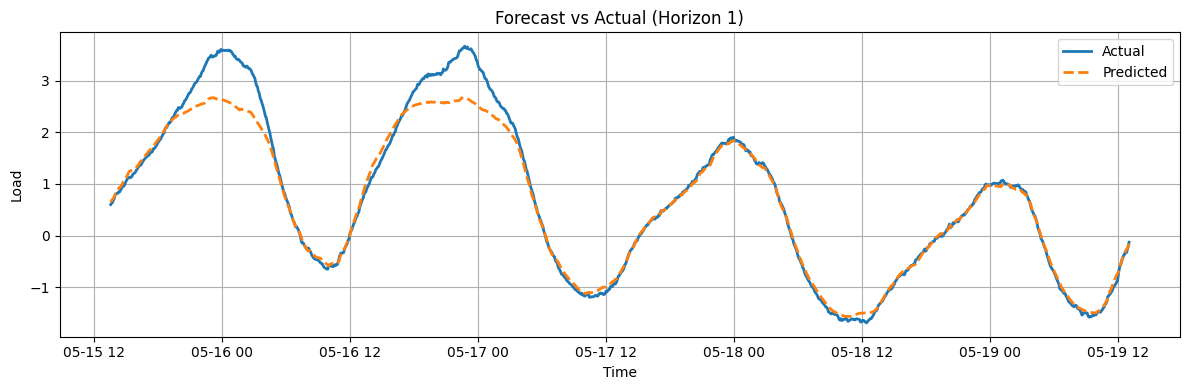

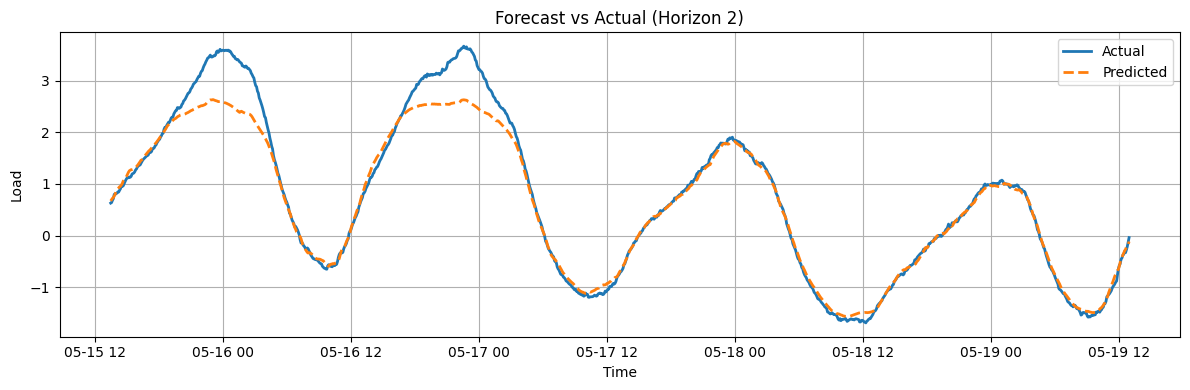

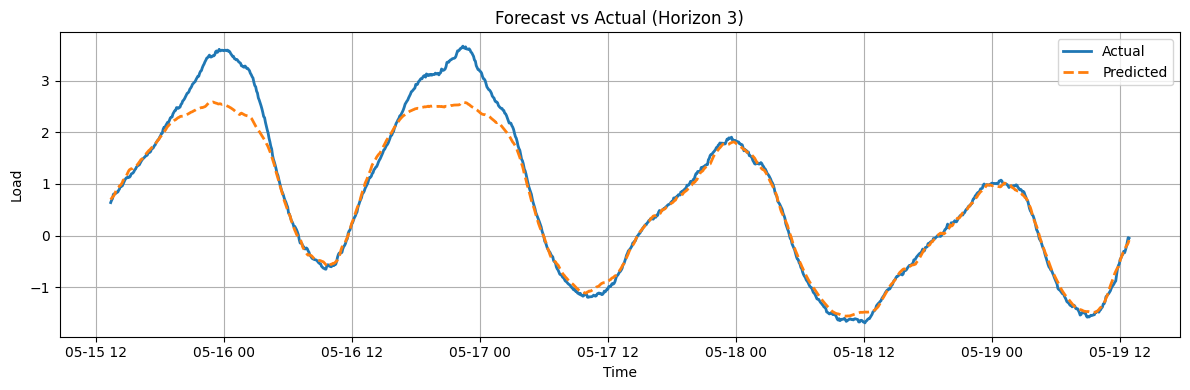

In [302]:
plot_test_vs_pred_time(test_df, y_true, y_pred, horizons=[1,2,3])